In [1]:
import os
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('../../')

In [3]:
processed_data = pd.read_csv('data/selected/data.csv')

In [5]:
X, y = processed_data.drop('Ilg', axis=1), processed_data['Ilg']

In [6]:
reg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', Lasso())
])

In [7]:
params = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'estimator__alpha': np.logspace(-6, 6, 13), 
    'estimator__max_iter': [10, 100, 1000, 5000, 10000],
    'estimator__tol': [1e-4, 1e-3, 1e-2]
}

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+05, tolerance: 7.914e+03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.986e+05, tolerance: 7.589e+03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

Best score:  143.31631822323246
Best params:  {'estimator__alpha': 1e-06, 'estimator__max_iter': 10, 'estimator__tol': 0.0001, 'scaler': StandardScaler()}


/var/folders/z2/x55d_0sd3zl143hy_l05bnpr0000gn/T/ipykernel_3918/1281215345.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df, y=X.columns, palette='plasma')


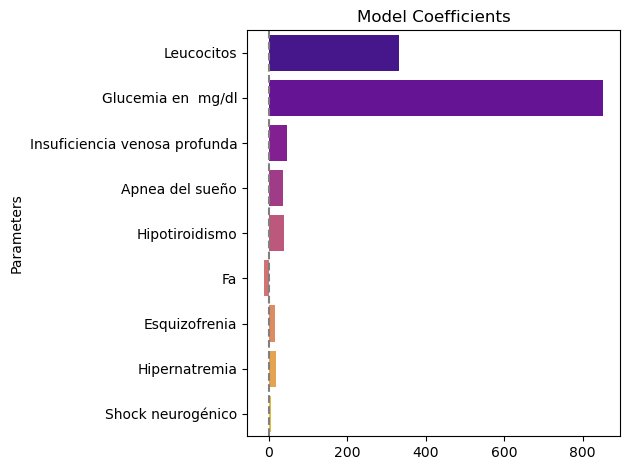

In [8]:
with mlflow.start_run():

    grid = GridSearchCV(estimator=reg, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid.fit(X, y)

    mlflow.log_param('model_type', 'regression')
    for param, value in grid.best_params_.items():
        mlflow.log_param(param, value)
    
    mlflow.log_metric("best_score", np.sqrt(-grid.best_score_))
    mlflow.sklearn.log_model(grid.best_estimator_, 'Lasso')

    print('Best score: ', np.sqrt(-grid.best_score_))
    print('Best params: ', grid.best_params_)

    coef_df = grid.best_estimator_.named_steps['estimator'].coef_

    sns.barplot(x=coef_df, y=X.columns, palette='plasma')
    plt.title('Model Coefficients')
    plt.ylabel('Parameters')
    plt.axvline(0, color='grey', linestyle='--')
    plt.tight_layout()

    mlflow.log_figure(plt.gcf(), 'lasso_coefficients.png')
    plt.show()